# 1. Configuración Inicial

In [18]:
# Parametros Iniciales
RAW_DIR = r"D:\Jupyter_Notebooks\proyecto-restauradores\data\raw"
OUTPUT_PARQUET = "data/summary.parquet"  # artefacto final que lee la app

In [19]:
# --- Asegurar que el cwd sea la raíz del proyecto (no otra ubicacion) ---
import os, pathlib
nb_dir = pathlib.Path().resolve()
# si estamos dentro de /notebooks, subir un nivel
if nb_dir.name.lower() == "notebooks":
    os.chdir(nb_dir.parent)
print("cwd ->", os.getcwd())

cwd -> D:\Jupyter_Notebooks\proyecto-restauradores


In [20]:
"""

# Celda: utilitario de conversión .xls → .xlsx (LibreOffice headless)
from pathlib import Path
import subprocess, shutil

def ensure_xlsx(path: Path) -> Path:
    "Si 'path' es .xls, lo convierte a .xlsx con LibreOffice (soffice --headless) y devuelve la ruta .xlsx. Si ya es .xlsx, devuelve el original."

    path = Path(path)
    if path.suffix.lower() == ".xlsx":
        return path
    if path.suffix.lower() != ".xls":
        raise ValueError(f"Extensión no soportada: {path.suffix} (esperaba .xls o .xlsx)")

    xlsx_path = path.with_suffix(".xlsx")

    # Ubicar 'soffice' (Windows/Linux/Mac)
    soffice = shutil.which("soffice")
    # Rutas típicas de Windows si no está en PATH
    if not soffice:
        posibles = [
            r"C:\Program Files\LibreOffice\program\soffice.exe",
            r"C:\Program Files (x86)\LibreOffice\program\soffice.exe"
        ]
        for p in posibles:
            if Path(p).exists():
                soffice = p
                break

    if not soffice or not Path(soffice).exists():
        raise RuntimeError(
            "No se encontró LibreOffice (soffice). "
            "Instálalo para conversión automática o convierte manualmente a .xlsx."
        )

    # Ejecutar conversión headless
    cmd = [soffice, "--headless", "--convert-to", "xlsx", "--outdir", str(path.parent), str(path)]
    subprocess.check_call(cmd)

    if not xlsx_path.exists():
        raise RuntimeError(f"No se generó {xlsx_path.name}. Revisa el archivo fuente {path.name}.")
    return xlsx_path

    """


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\GeovannyB\AppData\Local\Temp\ipykernel_17692\2126314387.py:1: SyntaxWarning: invalid escape sequence '\P'
  """


'\n\n# Celda: utilitario de conversión .xls → .xlsx (LibreOffice headless)\nfrom pathlib import Path\nimport subprocess, shutil\n\ndef ensure_xlsx(path: Path) -> Path:\n    "Si \'path\' es .xls, lo convierte a .xlsx con LibreOffice (soffice --headless) y devuelve la ruta .xlsx. Si ya es .xlsx, devuelve el original."\n\n    path = Path(path)\n    if path.suffix.lower() == ".xlsx":\n        return path\n    if path.suffix.lower() != ".xls":\n        raise ValueError(f"Extensión no soportada: {path.suffix} (esperaba .xls o .xlsx)")\n\n    xlsx_path = path.with_suffix(".xlsx")\n\n    # Ubicar \'soffice\' (Windows/Linux/Mac)\n    soffice = shutil.which("soffice")\n    # Rutas típicas de Windows si no está en PATH\n    if not soffice:\n        posibles = [\n            r"C:\\Program Files\\LibreOffice\\program\\soffice.exe",\n            r"C:\\Program Files (x86)\\LibreOffice\\program\\soffice.exe"\n        ]\n        for p in posibles:\n            if Path(p).exists():\n                soff

In [21]:
# Elegir el ultimo archivo actualizado dependiendo de la nomenclatura del nombre de archivo y para que lea .xls
import re, pathlib as pl

RAW = pl.Path(RAW_DIR)
assert RAW.exists(), f"No existe carpeta RAW: {RAW}"

# Patrones con tu nomenclatura oficial
pat_v = re.compile(r"ventas_(\d{2})_(\d{4})\.xls[x]?$", re.IGNORECASE)       # ventas_MM_YYYY
pat_c = re.compile(r"compras_(\d{2})_(\d{4})\.xls[x]?$", re.IGNORECASE)      # compras_MM_YYYY
pat_i = re.compile(r"inventario_(\d{8})\.xls[x]?$", re.IGNORECASE)           # inventario_YYYYMMDD

ventas_files  = [p for p in RAW.glob("ventas_*.xls*") if pat_v.match(p.name)]
compras_files = [p for p in RAW.glob("compras_*.xls*") if pat_c.match(p.name)]
inv_files     = [p for p in RAW.glob("inventario_*.xls*") if pat_i.match(p.name)]

if not ventas_files:
    raise FileNotFoundError("No hay archivos ventas_MM_YYYY.xls(x) en data/raw")
if not compras_files:
    raise FileNotFoundError("No hay archivos compras_MM_YYYY.xls(x) en data/raw")
if not inv_files:
    raise FileNotFoundError("No hay archivos inventario_YYYYMMDD.xls(x) en data/raw")

# Elegir el mes más reciente de ventas
def key_mes(p):
    mm, yyyy = pat_v.match(p.name).groups()
    return (int(yyyy), int(mm))

ventas_latest = max(ventas_files, key=key_mes)
mm = int(pat_v.match(ventas_latest.name).group(1))
yyyy = int(pat_v.match(ventas_latest.name).group(2))

ventas_path  = RAW / f"ventas_{mm:02d}_{yyyy}.xlsx"
if not ventas_path.exists():
    ventas_path = RAW / f"ventas_{mm:02d}_{yyyy}.xls"

compras_path = RAW / f"compras_{mm:02d}_{yyyy}.xlsx"
if not compras_path.exists():
    compras_path = RAW / f"compras_{mm:02d}_{yyyy}.xls"

# Inventario más reciente según fecha
def inv_key(p):
    yyyymmdd = int(pat_i.match(p.name).group(1))
    return yyyymmdd

inventario_latest = max(inv_files, key=inv_key)
inventario_path = RAW / (inventario_latest.stem + ".xlsx")
if not inventario_path.exists():
    inventario_path = RAW / (inventario_latest.stem + ".xls")

print("\nSeleccionados:")
print("  Ventas     ->", ventas_path.name)
print("  Compras    ->", compras_path.name)
print("  Inventario ->", inventario_path.name)



Seleccionados:
  Ventas     -> ventas_07_2025.xlsx
  Compras    -> compras_07_2025.xlsx
  Inventario -> inventario_20250805.xlsx


In [22]:
# Columnas mínimas que usa la app (ajústalas si tu app necesita más)
COLS_APP = [
    "CODIGO", "PRODUCTO", "CATEGORIA", "SUBCATEGORIA", "MARCA", "COMERCIO",
    "PROMEDIO_DIAS_VENTAS", "margen_bruto_%", "metrica_margen_bruto",
    "beneficio_promedio_por_producto", "STOCK", "unidades_vendidas_totales",
    "TIEMPO_PROMEDIO_VENTAS"
]


In [23]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
from pathlib import Path
import subprocess, shutil

def ensure_xlsx(path: Path) -> Path:
    """
    Si 'path' es .xls, lo convierte a .xlsx con LibreOffice (soffice --headless)
    y devuelve la ruta .xlsx. Si ya es .xlsx, devuelve el original.
    """
    path = Path(path)
    if path.suffix.lower() == ".xlsx":
        return path
    if path.suffix.lower() != ".xls":
        raise ValueError(f"Extensión no soportada: {path.suffix} (esperaba .xls o .xlsx)")

    xlsx_path = path.with_suffix(".xlsx")

    # Buscar 'soffice' (PATH o rutas típicas en Windows)
    candidatos = [
        shutil.which("soffice"),
        r"C:\Program Files\LibreOffice\program\soffice.exe",
        r"C:\Program Files (x86)\LibreOffice\program\soffice.exe",
    ]
    soffice = next((p for p in candidatos if p and Path(p).exists()), None)

    if not soffice:
        raise RuntimeError(
            "No se encontró LibreOffice (soffice). "
            "Instálalo o ajusta la ruta en ensure_xlsx."
        )

    cmd = [soffice, "--headless", "--convert-to", "xlsx", "--outdir", str(path.parent), str(path)]
    subprocess.check_call(cmd)

    if not xlsx_path.exists():
        raise RuntimeError(f"No se generó {xlsx_path.name}. Revisa el archivo fuente {path.name}.")
    return xlsx_path



In [25]:
# Conversión .xls -> .xlsx si hace falta
ventas_path     = ensure_xlsx(ventas_path)
compras_path    = ensure_xlsx(compras_path)
inventario_path = ensure_xlsx(inventario_path)

In [26]:
def agregar_variable(
    df_origen,
    df_destino,
    nombre_variable,
    nombre_destino=None,
    key='CODIGO',
    inplace=False
):
    """
    Extrae la columna `nombre_variable` de df_origen y la añade al DataFrame destino,
    devolviendo una copia por defecto (no modifica el df_destino original).

    Parámetros
    ----------
    df_origen : pandas.DataFrame
        DataFrame que contiene la variable a extraer.
    df_destino : pandas.DataFrame
        DataFrame al que se añadirá la nueva columna (o su copia).
    nombre_variable : str
        Nombre de la columna en df_origen que queremos copiar.
    nombre_destino : str, opcional
        Nombre de la columna en el DataFrame resultante. Si no se indica, se usa nombre_variable.
    key : str, por defecto 'CODIGO'
        Nombre de la columna clave en ambos DataFrames para hacer el mapeo.
    inplace : bool, por defecto False
        Si True, modifica df_destino en sitio; si False, trabaja sobre una copia y deja
        el df_destino intacto.

    Retorna
    -------
    pandas.DataFrame
        DataFrame con la nueva columna añadida.
    """
    if nombre_destino is None:
        nombre_destino = nombre_variable

    # Nos quedamos con la primera aparición de cada clave en el origen
    df_unicas = df_origen.drop_duplicates(subset=[key], keep='first')
    # Creamos el mapping clave → valor
    mapping = df_unicas.set_index(key)[nombre_variable]

    # Elegimos destino: copia o el original según inplace
    df_res = df_destino if inplace else df_destino.copy()

    # Asignamos la nueva columna
    df_res[nombre_destino] = df_res[key].map(mapping)

    return df_res

## 1.1. Inventario

In [27]:
# Skip the unnecessary rows and set appropriate headers based on the structure
inventario = pd.read_excel(inventario_path, skiprows=3)

# Creamos una nueva columna para CATEGORIAS, en el excel cada categoria se encuentra como encabezado. Para mejor manejo de datos creamos esta nueva columna
inventario['CATEGORIA'] = inventario['CODIGO'].where(inventario['DESCRIPCION'].isna()).ffill()

# ELiminamos la categoria SIN CATEGORIA
inventario = inventario[inventario['CATEGORIA'] != 'SIN CATEGORIA']

# Luego creamos los nombres para las columnas
nombre_columnas = [
    "CODIGO", "PRODUCTO", "MARCA", "STOCK", 
    "COSTO", "TOTAL", "PVP", "VALOR1", "CATEGORIA"
]

# Asignamos los nuevos nombres de columnas
inventario.columns = nombre_columnas

In [28]:
# 1. Elimina la columna VALOR1
inventario = inventario.drop(['VALOR1'], axis=1, errors='ignore')

# 2. Elimina las filas con valor nulo
inventario = inventario.dropna(how='any').reset_index(drop=True)

# 3. Eliminar duplicados. Estos duplicados corresponden al stock de TALLER, ya que el sistema arroja todos los codigos para cada comercio
# Ordenamos para priorizar registros con stock > 0
inventario = inventario.sort_values(by=['CODIGO', 'STOCK'], ascending=[True, False])
# Eliminar duplicados manteniendo la fila con mayor stock (cualquier stock >0 sobre stock=0)
inventario = inventario.drop_duplicates(subset='CODIGO', keep='first')

# 4. cambiar valores de STOCK, COSTO Y TOTAL negativo a stock 0 
inventario[['STOCK', 'COSTO', 'TOTAL']] = inventario[['STOCK', 'COSTO', 'TOTAL']].clip(lower=0)

# 5. Eliminar los FUERA DE INVENTARIO
inventario = inventario[
    ~inventario['PRODUCTO']
      .astype(str)
      .str.contains('FUERA DE INVENTARIO|FUERA DE SERVICIO|FUERA DE INEVENTARIO', case=False, na=False)
].reset_index(drop=True)


## 1.2. Compras

In [29]:
# skiprows es para ignorar las primeras filas del excel.
compras = pd.read_excel(compras_path, skiprows=4)

# Luego creamos los nombres para las columnas
nombre_columnas = [
    "CODIGO", "FECHA", "PROVEEDOR", "TIPO", 
    "CANTIDAD", "PRODUCTO", "FECHA_SISTEMA", "COSTO_TOTAL_SIN_IVA"
]

# Asignamos los nuevos nombres de columnas
compras.columns = nombre_columnas

In [30]:
# 1. Elminamos observaciones/filas de compras que NO SON PRODUCTOS como TRANSPORTE, SUMINISTROS, OTROS GASTOS, etc
# Luego eliminamos todos los valores por debajo de {SERVICIO} que pertenecen a valores por servicio de transporte
# Compruebo que exista la columna que busco
if 'CODIGO' not in compras.columns:
    raise KeyError("La columna 'CODIGO' no existe en el DataFrame.")

# 2) Creo la máscara para detectar el marcador
mask = compras['CODIGO'].eq('SERVICIOS')

# 3) Sólo si aparece “SERVICIOS”, corto hasta antes de esa fila
if mask.any():
    # idxmax() me da la etiqueta (index label) de la primera True
    first_label = mask.idxmax()
    # get_loc() traduce esa etiqueta a posición entera
    pos = compras.index.get_loc(first_label)
    # slice hasta pos (excluyendo la fila de 'SERVICIOS') y limpio el índice
    compras = compras.iloc[:pos].reset_index(drop=True)

# 2. Eliminar las compras con "FUERA DE INVENTARIO"
compras = compras[
    ~compras['PRODUCTO']
      .astype(str)
      .str.contains('FUERA DE INVENTARIO|FUERA DE SERVICIO|FUERA DE INEVENTARIO', case=False, na=False)
].reset_index(drop=True)

# 3. Elimina la columna FECHA SISTEMA
compras = compras.drop(['FECHA_SISTEMA'], axis=1, errors='ignore')

# 4. Elimina las filas con valor nulo
compras = compras.dropna(how='any').reset_index(drop=True)

# 5. Agrega variable COSTO_UNITARIO_SIN_IVA
compras['COSTO_UNITARIO_SIN_IVA'] = compras.COSTO_TOTAL_SIN_IVA/compras.CANTIDAD

# 6. Cambiar costo de productos que tienen valores NEGATIVOS. Cambiar a costo 0
compras['COSTO_UNITARIO_SIN_IVA'] = compras['COSTO_UNITARIO_SIN_IVA'].clip(lower=0)

# 7. Agregamos 'CATEGORIA' a compras desde df inventario:
compras = agregar_variable(
    df_origen = inventario,
    df_destino = compras,
    nombre_variable='CATEGORIA'
)

# 8. Eliminar la categoria "SIN CATEGORIA"
compras = compras[compras['CATEGORIA'] != 'SIN CATEGORIA']

# DOCUMENTACION COMPRAS

# *****CORREGIR LA VARIABLE COSTO DEL REPORTE DE COMPRAS!!!
1. **COSTO_TOTAL_SIN_IVA**: Es el costo total (cantidad * costo_unitario) SIN IVA de cada factura de compra realizada. El costo NO corresponde al costo que hay en las facturas. Esta tomando el costo sin descuento de las facturas
2. **COSTO_UNITARIO_SIN_IVA**: Es el costo UNITARIO SIN IVA de cada producto 


## 1.3. Ventas

In [31]:
# skiprows es para ignorar las primeras filas del excel.
ventas = pd.read_excel(ventas_path, skiprows=4)

# Luego creamos los nombres para las columnas
nombre_columnas_ventas = [
    "FECHA", "CLIENTE", "FACTURA", "HORA", "CATEGORIA", "CODIGO", 
    "PRODUCTO", "CANTIDAD", "V_UNITARIO", "DESCUENTO", "IVA", 
    "V_TOTAL", "COSTO", "VENDEDOR", "VALOR_1", "VALOR_2"
]

# Asignamos los nuevos nombres de columnas
ventas.columns = nombre_columnas_ventas

In [32]:
# 1. Elimina las ultimas dos columnas
ventas = ventas.iloc[:, :-2]

# 2. Eliminar las ventas con "FUERA DE INVENTARIO"
ventas = ventas[
    ~ventas['PRODUCTO']
      .astype(str)
      .str.contains('FUERA DE INVENTARIO|FUERA DE SERVICIO|FUERA DE INEVENTARIO', case=False, na=False)
].reset_index(drop=True)

# 3. Elimina las filas con valor nulo
ventas = ventas.dropna(how='any').reset_index(drop=True)

# 4. Eliminar la categoria "SIN CATEGORIA"
ventas = ventas[ventas['CATEGORIA'] != 'SIN CATEGORIA']

# 5. Convertir FECHA en datetimeindex
ventas['FECHA'] = pd.to_datetime(ventas['FECHA'], format='%d/%m/%Y')

# 6. Cambiar costo de productos que tienen valores NEGATIVOS. Cambiar a costo 0
ventas['COSTO'] = ventas['COSTO'].clip(lower=0)

"""
# 6. Incluir la variable COSTO desde el DF compras
# Establecer un costo promedio del DF compras para cada producto de ventas. Si algun producto de ventas no esta en el df de compras, que le añada el valor de COSTO del DF ventas

avg_cost = compras.groupby('CODIGO', as_index=False)['COSTO_UNITARIO_SIN_IVA'] \
                  .mean() \
                  .set_index('CODIGO')['COSTO_UNITARIO_SIN_IVA']

# 7. Mapea ese promedio en ventas; donde falte, usa COSTO_VENTA
ventas['COSTO_PROMEDIO_UNITARIO'] = (
    ventas['CODIGO']
    .map(avg_cost)                    # trae el costo promedio de compras
    .fillna(ventas['COSTO'])          # si no existe, usa el costo de venta
)

# 8. Eliminar variable COSTO (Obsoleto)
# Se establece como costo oficial a la variable COSTO_PROMEDIO, ya que la variable COSTO del DF ventas coge solo el ultimo costo del sistema
#ventas = ventas.drop(['COSTO'], axis=1, errors='ignore')
"""

# 9. Crear categoria COMERCIO
ventas['COMERCIO'] = ventas['CATEGORIA'].map({
    'MAQUINARIA': 'ALMACEN',
    'ACCESORIO': 'ALMACEN',
    'REPUESTO': 'TALLER',
    'SERVICIO': 'TALLER'
})

# En lugar de tomar la variable COSTO_PROMEDIO del df compras, voy a utilizar la variable COSTO del df ventas (MODIFICADO)
ventas['COSTO_TOTAL_UNITARIO'] = ventas.COSTO * ventas.CANTIDAD
ventas['INGRESO_TOTAL_SIN_IVA'] = ventas.V_UNITARIO * ventas.CANTIDAD
ventas['UTILIDAD'] = ventas['INGRESO_TOTAL_SIN_IVA'] - ventas['COSTO_TOTAL_UNITARIO']

# 10. Se eliminan las ventas que han tenido UTILIDAD<0. Cosas como servicio de transporte, varillas, mangueras, etc  
ventas_limpio = ventas[ventas['UTILIDAD'] > 0]
#Como resultado se eliminaro 636 filas/observaciones de ventas que fueron obsequi y ventas con anomalias en cuanto a la utilidad

# OJO 
se esta tomando el COSTO de las ventas porque el COSTO que aparece en el reporte de compras en un costo donde NO se consideran los descuentos de la factura de compra. Anfibius debe corregir. Cuando Anfibius corrija eso, se puede usa el COSTO de compras para determinar el COSTO_PROMEDIO segun el codigo de arriba

In [33]:
def filtrar_por_palabras(df: pd.DataFrame,
                         column: str,
                         keyword: str,
                         case: bool = False) -> pd.DataFrame:
    """
    Filtra las filas de `df` manteniendo solo aquellas donde
    el texto en `column` contenga `keyword`, y devuelve un
    DataFrame sin códigos repetidos (solo primera aparición).

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada.
    column : str
        Nombre de la columna en la que buscar el keyword.
    keyword : str
        Texto o patrón a buscar dentro de la columna.
    case : bool, opcional
        Si True, la búsqueda distinguirá mayúsculas/minúsculas
        (por defecto False).

    Devuelve
    -------
    pd.DataFrame
        Subconjunto de filas donde df[column] contiene keyword,
        sin duplicados en la columna 'CODIGO'.
    """
    # Nos aseguramos de tratar la columna como string
    texto = df[column].astype(str)
    # Creamos la máscara de True/False
    mask = texto.str.contains(keyword, case=case, na=False)
    
    # Filtramos y hacemos copia para evitar SettingWithCopyWarning
    productos_con_filtro = df[mask].copy()
    
    # Eliminamos duplicados en 'CODIGO', quedándonos con la primera aparición
    productos_unicos = productos_con_filtro.drop_duplicates(
        subset=['CODIGO'],
        keep='first'
    )
    
    # Mensaje informativo
    if productos_unicos.empty:
        print(f"No se encontró ningún producto con la palabra '{keyword}'.")
    else:
        print(f"Se encontraron {len(productos_unicos)} productos con '{keyword}'")
    
    return productos_unicos

In [34]:
maqs = ventas[ventas['CATEGORIA'] == 'MAQUINARIA']
acss = ventas[ventas['CATEGORIA'] == 'ACCESORIO']

# Productos de ACCESORIOS dentro de MAQUINARIAS
broca = filtrar_por_palabras(maqs, 'PRODUCTO', 'BROCA')
disco = filtrar_por_palabras(maqs, 'PRODUCTO', 'DISCO')

#Productos de MAQUINARIAS dentro de ACCESORIOS
rotomartillo = filtrar_por_palabras(acss, 'PRODUCTO', 'ROTOMARTILLO')
taladro = filtrar_por_palabras(acss, 'PRODUCTO', 'TALADRO')
amoladora = filtrar_por_palabras(acss, 'PRODUCTO', 'AMOLADORA')
soldadora = filtrar_por_palabras(acss, 'PRODUCTO', 'SOLDADORA')

#rotomartillo[rotomartillo.CODIGO == 'R431']

Se encontraron 7 productos con 'BROCA'
Se encontraron 8 productos con 'DISCO'
Se encontraron 10 productos con 'ROTOMARTILLO'
Se encontraron 18 productos con 'TALADRO'
Se encontraron 4 productos con 'AMOLADORA'
Se encontraron 3 productos con 'SOLDADORA'


# DOCUMENTACION VENTAS

Descripcion de cada variable del df ventas:

1. **V_UNITARIO**: Corresponde al valor unitario de cada producto SIN IVA
2. **COSTO**: Es el costo UNITARIO de cada producto SIN IVA
3. **V_TOTAL**: Valor total de la venta INCLUIDO IVA

- IMPORTANTE: Corregir productos que estan mal ingresados. Productos que se venden "al granel" como varillas, mangueras, sierras para caladora, etc. Corregir productos mal CLASIFICADOS en categoria maquinaria, accesorios, repuestos, servicio
- PROHIBIDO: No cambiar los costos manualmente, solo modificar EQUIVALENCIAS en Anfibius

Ejemplos: 

- Cambiar en el sistema la categoria para "SELLO MECANICO" y 'ESCUADRA DACERO INOX. 12 ANGULO RECTO 90 WADFOW WSR2930' debe ser cambiado a CATEGORIA - REPUESTO y ACCESORIO respectivamente

In [35]:
# Exportar archivos limpios

"""
ventas.to_excel(
    'Data_limpia/ventas_limpio.xlsx',
    index=False,            # No incluye la columna de índice
)

compras.to_excel(
    'Data_limpia/compras_limpio.xlsx',
    index=False,            # No incluye la columna de índice
)

inventario.to_excel(
    'Data_limpia/inventario_012025.xlsx',
    index=False,            # No incluye la columna de índice
)
"""

"\nventas.to_excel(\n    'Data_limpia/ventas_limpio.xlsx',\n    index=False,            # No incluye la columna de índice\n)\n\ncompras.to_excel(\n    'Data_limpia/compras_limpio.xlsx',\n    index=False,            # No incluye la columna de índice\n)\n\ninventario.to_excel(\n    'Data_limpia/inventario_012025.xlsx',\n    index=False,            # No incluye la columna de índice\n)\n"

# 2. ANALISIS

# 2.1. TIEMPO

Lo que vamos a hacer es determinar el tiempo promedio de venta de cada producto tomando en cuenta la fecha que fue comprado y la fecha que fue vendido. Para esto seguimos el siguiente procedimiento:
1. Ordanamos por codigo y fecha los datasets de ventas y compras
2. Creamos una variable para distinguir que pertenece a una COMPRA o a una VENTA
3. Se crea un DF que combine las ventas y compras en orden cronologico (FECHA, CODIGO, CANTIDAD, TIPO_TRANSACCION)
4. Se crea un flujo de trabajo para determinar las distintas situaciones encontradas dentro del sistema de facturacion de acuerdo a una tabla de condiciones (ver excel Condiciones_Calculo_Tiempo_Ventas.xlsx)

In [36]:
# 1. Ordenamos los datasets de compras y ventas
compras_df = compras.sort_values(by=['CODIGO', 'FECHA']).reset_index(drop=True)
ventas_df = ventas_limpio.sort_values(by=['CODIGO', 'FECHA']).reset_index(drop=True)

# 2. Creamos una variable para distinguir que pertenece a una COMPRA o a una VENTA
compras_df['TIPO_TRANSACCION'] = 'COMPRA'
ventas_df['TIPO_TRANSACCION'] = 'VENTA'

# Seleccionamos las columnas de interes
compras_df_filtro = compras_df[['FECHA', 'CODIGO', 'CANTIDAD', 'TIPO_TRANSACCION']]
ventas_df_filtro = ventas_df[['FECHA', 'CODIGO', 'CANTIDAD', 'TIPO_TRANSACCION']]

# 3. Combinamos los DF de ventas y compras
combined_df = pd.concat([compras_df_filtro, ventas_df_filtro]).sort_values(by=['CODIGO', 'FECHA']).reset_index(drop=True)

In [37]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60606 entries, 0 to 60605
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA             60606 non-null  datetime64[ns]
 1   CODIGO            60606 non-null  object        
 2   CANTIDAD          60606 non-null  float64       
 3   TIPO_TRANSACCION  60606 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.8+ MB


In [38]:
# Comprobacion de organizacion de ventas por producto
combined_df[combined_df.CODIGO == '4082']

,FECHA,CODIGO,CANTIDAD,TIPO_TRANSACCION
18969,2023-05-12 12:16:00,4082,2.0,COMPRA
18970,2023-09-11 00:00:00,4082,1.0,VENTA
18971,2023-10-04 15:54:00,4082,3.0,COMPRA
18972,2023-11-27 00:00:00,4082,1.0,VENTA
18973,2023-12-22 00:00:00,4082,1.0,VENTA
18974,2024-01-29 10:34:00,4082,2.0,COMPRA
18975,2024-02-05 00:00:00,4082,1.0,VENTA
18976,2024-03-23 00:00:00,4082,1.0,VENTA
18977,2024-03-25 09:01:00,4082,4.0,COMPRA
18978,2024-06-03 00:00:00,4082,1.0,VENTA


AÑADIR UNA VARIABLE o una lista o un diccionario que contenga los valores de stock de cada codigo. Luego verificar si el codigo tiene stock>0, que cuente los dias desde la ultima venta hasta la fecha de hoy y luego incluya este conteo como una operacion mas y calcule el promedio tomando en cuenta esto ultimo. Tomar en cuenta solo los casos que tienen al menos una venta y que tienen stock>0

In [39]:
# 4. Flujo de trabajo para determinar el tiempo de venta para cada producto. Se detalla por categoria los diferentes casos que se han observado 
# en las ventas del sistema de facturacion. Ver el archivo excel para conocer como se clasificaron los tipos de casos de ventas.

# Parámetros fijos
STORE_OPEN = pd.Timestamp('2020-10-01')
TODAY      = pd.Timestamp.today().normalize()

# Asegurarnos de que la fecha es datetime
combined_df['FECHA']    = pd.to_datetime(combined_df['FECHA'])
inventario['CODIGO']    = inventario['CODIGO'].astype(combined_df['CODIGO'].dtype)

# 1) Construir un mapeo CODIGO → stock actual
stock_dict = inventario.set_index('CODIGO')['STOCK'].to_dict()

results = []

for codigo, group in combined_df.groupby('CODIGO'):
    group = group.sort_values('FECHA').reset_index(drop=True)
    tipos = group['TIPO_TRANSACCION'].tolist()
    fechas = group['FECHA'].tolist()

    n_compra = tipos.count('COMPRA')
    n_venta  = tipos.count('VENTA')
    diffs    = []

    # consulto stock para este código (0 si no existe en inventario)
    stock = stock_dict.get(codigo, 0)

    # 1) Caso 1. Hay compras y ventas
    if n_compra > 0 and n_venta > 0:
        # Sólo COMPRA→VENTA y VENTA→VENTA
        for i in range(1, len(tipos)):
            prev, curr = tipos[i-1], tipos[i]
            if (prev=='COMPRA' and curr=='VENTA') or (prev=='VENTA' and curr=='VENTA'):
                diffs.append((fechas[i] - fechas[i-1]).days)

        # Si tiene stock >0 y al menos una venta, incluyo tiempo desde última venta hasta hoy
        if stock > 0 and n_venta > 0:
            last_sale = group.loc[group['TIPO_TRANSACCION']=='VENTA', 'FECHA'].max()
            diffs.append((TODAY - last_sale).days)

        if diffs:
            avg_days = np.mean(diffs)
            max_days = np.max(diffs)
            min_days = np.min(diffs)
            ops      = len(diffs)
        else:
            avg_days = max_days = min_days = 0
            ops = 0
        obs = 'compra->venta y venta->venta'

    # 2) Caso 2. Sólo compras, nunca vendido
    elif n_compra > 0 and n_venta == 0:
        last_purchase = group.loc[group['TIPO_TRANSACCION']=='COMPRA','FECHA'].max()
        days_since    = (TODAY - last_purchase).days
        avg_days = max_days = min_days = days_since
        ops = 0
        obs = 'solo compras (sin venta)'

    # 3) Caso 3. Sólo ventas, sin compras
    elif n_compra == 0 and n_venta > 0:
        ventas_f = group.loc[group['TIPO_TRANSACCION']=='VENTA','FECHA'].sort_values()

        # si una sola venta, arranca desde apertura
        if len(ventas_f) == 1:
            days_from_open = (ventas_f.iloc[0] - STORE_OPEN).days
            diffs = [days_from_open]
        else:
            # varias ventas: inter-venta
            diffs = ventas_f.diff().dt.days.dropna().tolist()

        # si stock > 0, agrego días desde última venta hasta hoy
        if stock > 0:
            last_sale = ventas_f.max()
            diffs.append((TODAY - last_sale).days)

        # calcular estadísticas
        avg_days = np.mean(diffs)
        max_days = np.max(diffs)
        min_days = np.min(diffs)
        ops      = len(diffs)
        obs = 'venta única desde apertura' if len(ventas_f)==1 else 'venta->venta inicial múltiple'

    # 4) Caso borde (sin transacciones)
    else:
        avg_days = max_days = min_days = np.nan
        ops = 0
        obs = 'sin transacciones'

    results.append({
        'CODIGO':               codigo,
        'PROMEDIO_DIAS_VENTAS': avg_days,
        'MAXIMO_DIAS_VENTAS':   max_days,
        'MINIMO_DIAS_VENTAS':   min_days,
        'OPERACIONES':          ops,
        'OBSERVACIONES':        obs,
        'STOCK':                stock
    })

# Convertir a DataFrame para análisis final
tiempo_promedio_ventas = pd.DataFrame(results)

In [40]:
# 5.1. PRODUCTOS que NO fueron tomados en cuenta en el flujo de trabajo anterior 
# Son 36 productos que fueron facturados antes de ingresar factura de compra. Se realizo esto, para procesar ventas anticipadas.
# Se facturo primero y luego se ingreso la factura de compra

filtro_ventas_anticipadas = tiempo_promedio_ventas[
    (tiempo_promedio_ventas['OPERACIONES'] == 0) &
    (tiempo_promedio_ventas['PROMEDIO_DIAS_VENTAS'] == 0)
]
filtro_ventas_anticipadas.count()

CODIGO                  17
PROMEDIO_DIAS_VENTAS    17
MAXIMO_DIAS_VENTAS      17
MINIMO_DIAS_VENTAS      17
OPERACIONES             17
OBSERVACIONES           17
STOCK                   17
dtype: int64

In [41]:
tiempo_promedio_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5553 entries, 0 to 5552
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CODIGO                5553 non-null   object 
 1   PROMEDIO_DIAS_VENTAS  5553 non-null   float64
 2   MAXIMO_DIAS_VENTAS    5553 non-null   float64
 3   MINIMO_DIAS_VENTAS    5553 non-null   float64
 4   OPERACIONES           5553 non-null   int64  
 5   OBSERVACIONES         5553 non-null   object 
 6   STOCK                 5553 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 303.8+ KB


# 2.1.1. Variable Tiempo Promedio por Producto

In [42]:
compras[compras.CODIGO == "5800"]

,CODIGO,FECHA,PROVEEDOR,TIPO,CANTIDAD,PRODUCTO,COSTO_TOTAL_SIN_IVA,COSTO_UNITARIO_SIN_IVA,CATEGORIA
7701,5800,2024-11-27 08:27:00,FERREMUNDO S A-FERREMUNDO S.A.,Mercaderia,6.0,PINTURA SPRAY NEGRO BRILLANTE #39 SOL COLOR,7.92,1.32,ACCESORIO


In [43]:
# 1. Creamos variable TIEMPO PROMEDIO DE VENTAS
#Definimos los límites de los rangos y sus etiquetas
intervalos_tiempo  = [0, 60, 120, 180, np.inf]
labels = ['Estrella', 'Optimo', 'Tomar Acción', 'Tomar Acción Urgente']

# 2. Creamos el variable de acuerdo a los intervalos establecidos
tiempo_promedio_ventas['TIEMPO_PROMEDIO_VENTAS'] = pd.cut(
    tiempo_promedio_ventas['PROMEDIO_DIAS_VENTAS'],
    bins=intervalos_tiempo,
    labels=labels,
    right=True,       # el límite superior está incluido en cada bin
    include_lowest=True
)
tiempo_promedio_ventas

# 3. Agregamos 'CATEGORIA' y "PRODUCTO" a tiempo_promedio_ventas:
# Creamos dos Series indexadas por CODIGO para CATEGORIA y PRODUCTO
map_compras_cat  = compras.groupby('CODIGO')['CATEGORIA'].first()
map_ventas_cat   = ventas_limpio.groupby('CODIGO') ['CATEGORIA'].first()

map_compras_prod = compras.groupby('CODIGO')['PRODUCTO'].first()
map_ventas_prod  = ventas_limpio.groupby('CODIGO')['PRODUCTO'].first()

# Asignamos directamente CATEGORIA desde compras y ventas a tiempo_promedio_ventas
tiempo_promedio_ventas['CATEGORIA'] = (
    # Primero, intentamos con compras
    tiempo_promedio_ventas['CODIGO'].map(map_compras_cat)
    # Si sigue NaN, lo completamos con ventas
    .fillna(tiempo_promedio_ventas['CODIGO'].map(map_ventas_cat))
)

# Asignamos directamente PRODUCTO desde compras y ventas a tiempo_promedio_ventas
tiempo_promedio_ventas['PRODUCTO'] = (
    # Primero, intentamos con compras
    tiempo_promedio_ventas['CODIGO'].map(map_compras_prod)
    # Si sigue NaN, lo completamos con ventas
    .fillna(tiempo_promedio_ventas['CODIGO'].map(map_ventas_prod))
)

# 4. Creamos la categoria COMERCIO
tiempo_promedio_ventas['COMERCIO'] = tiempo_promedio_ventas['CATEGORIA'].map({
    'MAQUINARIA': 'ALMACEN',
    'ACCESORIO': 'ALMACEN',
    'REPUESTO': 'TALLER',
    'SERVICIO': 'TALLER'
    #'NO ESPECIFICA EN REPORTE COMPRAS': 'SIN COMERCIO'
})

# 5. Eliminamos los valores nulos que corresponden a productos SIN CATEGORIA. Son productos como BANDEROLAS, SEGURO TRANSPORTE, EXHIBIDOR, etc
tiempo_promedio_ventas.dropna(inplace=True)

tiempo_promedio_ventas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5547 entries, 0 to 5552
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CODIGO                  5547 non-null   object  
 1   PROMEDIO_DIAS_VENTAS    5547 non-null   float64 
 2   MAXIMO_DIAS_VENTAS      5547 non-null   float64 
 3   MINIMO_DIAS_VENTAS      5547 non-null   float64 
 4   OPERACIONES             5547 non-null   int64   
 5   OBSERVACIONES           5547 non-null   object  
 6   STOCK                   5547 non-null   float64 
 7   TIEMPO_PROMEDIO_VENTAS  5547 non-null   category
 8   CATEGORIA               5547 non-null   object  
 9   PRODUCTO                5547 non-null   object  
 10  COMERCIO                5547 non-null   object  
dtypes: category(1), float64(4), int64(1), object(5)
memory usage: 482.3+ KB


# Incluir aspecto dinamico
1. Calcular un STOCK_PYTHON. Este es un stock calculado a partir de las COMPRAS y VENTAS de cada producto
2. Si y solo si tiene aun stock el producto, tomar en cuenta el tiempo desde la ultima venta, hasta la fecha de hoy. Con esto agregamos la componente dinamica dentro del analisis
3. Tambien se podria incluir directamente el stock desde INVENTARIO hacia el df TIEMPO_PROMEDIO_ALMACEN


In [44]:
inventario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CODIGO     6046 non-null   object 
 1   PRODUCTO   6046 non-null   object 
 2   MARCA      6046 non-null   object 
 3   STOCK      6046 non-null   float64
 4   COSTO      6046 non-null   float64
 5   TOTAL      6046 non-null   float64
 6   PVP        6046 non-null   float64
 7   CATEGORIA  6046 non-null   object 
dtypes: float64(4), object(4)
memory usage: 378.0+ KB


# Documentacion

1. **compra->venta y venta->venta**: En este caso hay varias compras y ventas, y solo cuenta el tiempo de ventas SOLO si sigue la secuencia COMPRA-VENTA y VENTA-VENTA. Nunca contabiliza la diferencia entre fechas cuando sea VENTA-COMPRA ni tampoco COMPRA-COMPRA.
2. **solo compras (sin venta)**: Estos son productos que se han comprado y nunca se han vendido. Se toma el tiempo de venta como el tiempo que sigue en stock desde que se compro hasta la fecha actual
3. **venta única desde apertura**: Productos que no han tenido ninguna compra pero muestran que han tenido una sola venta. Se puede interpretar como productos que solo se vendieron una vez (desde el inventario inicial) y se decidio no comprar mas ese producto. Se calculo como la diferencia entre la fecha de apertura y la fecha de esa unica venta.
4. **venta->venta inicial múltiple**: Productos que no reflejen ninguna Compra solo reflejan ventas.


IMPORTANTE: Dentro de este analisis no se incluyen 36 productos que se han comprado bajo pedido, en donde primero se realizo la factura de venta y luego se ha ingresado la factura de compra al sistema. CORREGIR para NO volver a realizar esto. Primero se debe ingresar la factura de compra y luego realizar la factura de venta. Caso contrario no proceder por ningun motivo. Esto crea un conflicto ya que en el sistema se esatria vendiendo un producto sin que haya ingresado como compra. (NO REALIZAR INGRESOS MANUAL DE PRODUCTO PARA REALIZAR UNA VENTA BAJO PEDIDO O VENTA ANTICIPADA).

Para reconocer estos 36 productos realizamos un filtro cuando OPERACIONES, PROMEDIO_DIAS_VENTAS, MAXIMO_DIAS_VENTAS y MINIMO_DIAS_VENTAS tienen un valor de 0

# 2.1.2. Grafico Tiempo Promedio ALMACEN

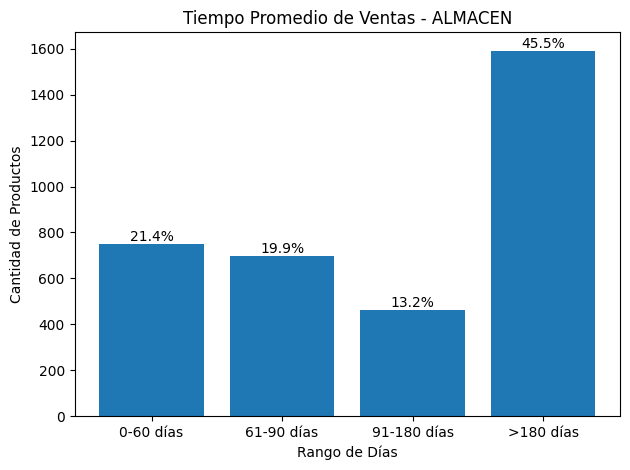

In [45]:
# Crear variable para ALMACEN
tiempo_promedio_almacen = tiempo_promedio_ventas[tiempo_promedio_ventas.COMERCIO == "ALMACEN"]

# Definir orden de categorías originales y sus etiquetas numéricas de reemplazo
categories = ['Estrella', 'Optimo', 'Tomar Acción', 'Tomar Acción Urgente']
display_labels = ['0-60 días', '61-90 días', '91-180 días', '>180 días']

# Contar productos por categoría y reindexar para conservar orden
counts = tiempo_promedio_almacen['TIEMPO_PROMEDIO_VENTAS'].value_counts().reindex(categories, fill_value=0)

# Cálculo de porcentajes
total = counts.sum()
percentages = counts / total * 100

# Crear figura y ejes
fig, ax = plt.subplots()
bars = ax.bar(categories, counts)

# Añadir etiquetas de porcentaje encima de cada barra
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct:.1f}%",
        ha='center',
        va='bottom'
    )

# Reemplazar etiquetas del eje X
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(display_labels)

# Etiquetas y título
ax.set_xlabel('Rango de Días')
ax.set_ylabel('Cantidad de Productos')
ax.set_title('Tiempo Promedio de Ventas - ALMACEN')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2.1.3. Grafico Tiempo Promedio TALLER

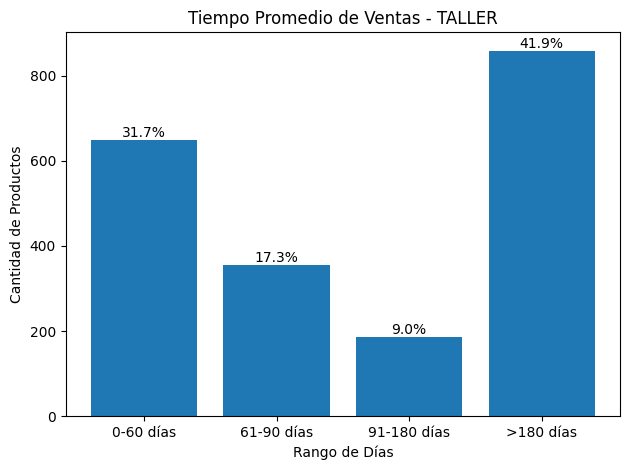

In [46]:
# Crear variable para ALMACEN
tiempo_promedio_taller = tiempo_promedio_ventas[tiempo_promedio_ventas.COMERCIO == "TALLER"]

# Definir orden de categorías originales y sus etiquetas numéricas de reemplazo
categories = ['Estrella', 'Optimo', 'Tomar Acción', 'Tomar Acción Urgente']
display_labels = ['0-60 días', '61-90 días', '91-180 días', '>180 días']

# Contar productos por categoría y reindexar para conservar orden
counts = tiempo_promedio_taller['TIEMPO_PROMEDIO_VENTAS'].value_counts().reindex(categories, fill_value=0)

# Cálculo de porcentajes
total = counts.sum()
percentages = counts / total * 100

# Crear figura y ejes
fig, ax = plt.subplots()
bars = ax.bar(categories, counts)

# Añadir etiquetas de porcentaje encima de cada barra
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct:.1f}%",
        ha='center',
        va='bottom'
    )

# Reemplazar etiquetas del eje X
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(display_labels)

# Etiquetas y título
ax.set_xlabel('Rango de Días')
ax.set_ylabel('Cantidad de Productos')
ax.set_title('Tiempo Promedio de Ventas - TALLER')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2.2 UTILIDAD BRUTA

In [47]:
# 1. Calcular MARGEN BRUTO. Ahora realizamos el analisis por producto, es decir, sumar todos los ingresos y costos variables por producto 
    # para obtener resultados a nivel de producto individual

# En lugar de tomar la variable COSTO_PROMEDIO del df compras, voy a utilizar la variable COSTO del df ventas
# Recordar que: ventas_limpio['COSTO_TOTAL_UNITARIO'] = ventas_limpio.COSTO * ventas_limpio.CANTIDAD
# Recordar que: ventas_limpio['INGRESO_TOTAL_SIN_IVA'] = ventas_limpio.V_UNITARIO * ventas_limpio.CANTIDAD

# Agrupamos por producto (CODIGO)
margen_bruto = ventas_limpio.groupby('CODIGO').agg(
    ingresos_totales            = ('INGRESO_TOTAL_SIN_IVA', 'sum'),
    costo_variable_total        = ('COSTO_TOTAL_UNITARIO', 'sum'),
    unidades_vendidas_totales   = ('CANTIDAD', 'sum')
).reset_index()

# Calculamos el margen bruto
margen_bruto['margen_bruto'] = margen_bruto['ingresos_totales'] - margen_bruto['costo_variable_total']

# Calculamos el margen bruto porcentual
margen_bruto['margen_bruto_%'] = ((margen_bruto.ingresos_totales - margen_bruto.costo_variable_total) / margen_bruto.ingresos_totales) * 100

# 2. Asignar COSTOS FIJOS TOTALES a cada producto 

# a. Definimos el costo fijo total de la empresa
COSTOS_FIJOS = 5000*12*5 # Modificar para que sea mensual y lo calcule automaticamente del historico. Compras y Ventas.
# Dependiendo del intervalo desde compra a venta o venta a venta o compra a fecha de hoy para stock>0 asignar o alocar los costos fijos producto por producto

# b. Calculamos los ingresos totales de la empresa
ingresos_totales_empresa = margen_bruto['ingresos_totales'].sum()

# c. Calculamos el porcentaje de participacion por producto
margen_bruto['%_ingresos'] = margen_bruto['ingresos_totales'] / ingresos_totales_empresa

# d. Asignamos el valor en dolares a cada producto, segun el porcentaje de ingresos de los costos fijos 
margen_bruto['costos_fijos_asignados'] = (
    margen_bruto['%_ingresos'] * COSTOS_FIJOS
)

# e. Calculamos el beneficio neto restando esos costos fijos del margen bruto
margen_bruto['beneficio_neto'] = (
    margen_bruto['margen_bruto'] - margen_bruto['costos_fijos_asignados']
)

# 3. Calculamos el beneficio promedio por producto.
margen_bruto['beneficio_promedio_por_producto'] = margen_bruto['beneficio_neto'] / margen_bruto['unidades_vendidas_totales']

# 4. Creamos una variable discreta del beneficio promedio por producto
# Definimos los puntos de corte y sus etiquetas
bins   = [-np.inf,  0,   10,   100, np.inf]
labels = ['Perdida', 'Beneficio Bajo', 'Beneficio Medio', 'Beneficio Alto']

# Creamos la nueva columna con los cortes
margen_bruto['metrica_margen_bruto'] = pd.cut(
    margen_bruto['beneficio_promedio_por_producto'],
    bins=bins,
    labels=labels,
    right=False,        # intervalos tipo [a, b)
    include_lowest=True # incluye -inf en el primer bin
)

# 5. Quiero agregar 'CATEGORIA' a margen_bruto:
for var in ['PRODUCTO', 'CATEGORIA', 'COMERCIO', 'COSTO']:
    margen_bruto = agregar_variable(
        df_origen=ventas_limpio,
        df_destino=margen_bruto,
        nombre_variable=var
    )

# 6. Agrego STOCK a margen bruto
margen_bruto = agregar_variable(
    df_origen = inventario,
    df_destino = margen_bruto,
    nombre_variable='STOCK'
)

In [48]:
margen_bruto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4544 entries, 0 to 4543
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   CODIGO                           4544 non-null   object  
 1   ingresos_totales                 4544 non-null   float64 
 2   costo_variable_total             4544 non-null   float64 
 3   unidades_vendidas_totales        4544 non-null   float64 
 4   margen_bruto                     4544 non-null   float64 
 5   margen_bruto_%                   4544 non-null   float64 
 6   %_ingresos                       4544 non-null   float64 
 7   costos_fijos_asignados           4544 non-null   float64 
 8   beneficio_neto                   4544 non-null   float64 
 9   beneficio_promedio_por_producto  4544 non-null   float64 
 10  metrica_margen_bruto             4544 non-null   category
 11  PRODUCTO                         4544 non-null   object  
 12  CATEGO

# Obtencion real del beneficio neto tomando en cuenta los intervalos de diempo y costos fijos reales

In [49]:
# Parámetros
STORE_OPEN = pd.Timestamp('2020-10-01')
TODAY      = pd.Timestamp.today().normalize()

# 1) Cargar y preparar datos
combined_df      = combined_df.copy()
ventas_limpio    = ventas_limpio.copy()
inventario      = inventario.copy()
costos_fijos_raw = pd.read_excel('data/raw/costos_fijos_historico.xlsx', sheet_name=0)

# Preparar costos fijos mensuales
costos_fijos_raw['FECHA'] = pd.to_datetime(costos_fijos_raw['FECHA'])
costos_fijos_raw['MES']   = costos_fijos_raw['FECHA'].dt.to_period('M')
monthly_costs = (
    costos_fijos_raw
    .groupby('MES', as_index=True)[['ALMACEN','TALLER']]
    .sum()
)

# Mapeo de stock por producto
stock_map = inventario.set_index('CODIGO')['STOCK'].to_dict()

# Asegurar datetime en los DataFrames clave
combined_df['FECHA']    = pd.to_datetime(combined_df['FECHA'])
ventas_limpio['FECHA']  = pd.to_datetime(ventas_limpio['FECHA'])

results = []

# 2) Bucle por producto
for codigo, group in combined_df.groupby('CODIGO'):
    grp = group.sort_values('FECHA').reset_index(drop=True)
    n_compra = (grp['TIPO_TRANSACCION']=='COMPRA').sum()
    n_venta  = (grp['TIPO_TRANSACCION']=='VENTA').sum()
    stock    = stock_map.get(codigo, 0)

    # Si nunca se vendió, no tiene beneficio neto
    if n_venta == 0:
        results.append({
            'CODIGO':                           codigo,
            'costos_fijos_asignados':           np.nan,
            'beneficio_neto':                   np.nan,
            'beneficio_promedio_por_producto':  np.nan
        })
        continue

    # 2.1) Determinar intervalo de exposición
    if n_compra > 0:
        start_date = grp.loc[grp['CODIGO'] == codigo,'FECHA'].min()
    else:
        start_date = STORE_OPEN

    if stock > 0:
        end_date = TODAY
    else:
        end_date = grp.loc[grp["CODIGO"] == codigo,'FECHA'].max()

    # 2.2) Meses completos en el intervalo
    start_mes = start_date.to_period('M')
    end_mes   = end_date.to_period('M')
    meses_intervalo = pd.period_range(start_mes, end_mes, freq='M')

    # 2.3) Ventas e ingresos en el intervalo
    mask_prod = (
        (ventas_limpio['CODIGO']==codigo) &
        (ventas_limpio['FECHA']>=start_date) &
        (ventas_limpio['FECHA']<=end_date)
    )
    df_p = ventas_limpio.loc[mask_prod]
    ingresos_prod  = df_p['INGRESO_TOTAL_SIN_IVA'].sum()
    unidades_prod  = df_p['CANTIDAD'].sum()
    costo_var_prod = df_p['COSTO_TOTAL_UNITARIO'].sum()

    # 2.4) Margen bruto del producto
    margen_bruto_prod = ingresos_prod - costo_var_prod

    # 2.4.1) Margen bruto en %
    margen_bruto_pct = (margen_bruto_prod / ingresos_prod) if ingresos_prod > 0 else np.nan

    # 2.5) Ingresos de la empresa en meses completos del intervalo
    ingresos_emp = (
        ventas_limpio
        .loc[ventas_limpio['FECHA'].dt.to_period('M').isin(meses_intervalo),
             'INGRESO_TOTAL_SIN_IVA']
        .sum()
    )
    
    # Se anade las ventas aproximadas de la empresa durante el periodo 2021-09 a 2020-09 para aquellos productos
    # que tienen ventas y no tienen compras registradas, por lo tanto se asume que han estado desde la apertura 
    if n_compra == 0:
        ingresos_emp += 216000
    
    pct_ingresos = ingresos_prod / ingresos_emp if ingresos_emp>0 else 0

    # 2.6) Sumar costos fijos del intervalo según ALMACEN/TALLER
    comercio = ventas_limpio.loc[ventas_limpio['CODIGO']==codigo,'COMERCIO'].iloc[0]
    cf_total = monthly_costs.loc[meses_intervalo, comercio].sum()

    # 2.7) Costos fijos asignados
    costos_fijos_asignados = pct_ingresos * cf_total

    # 2.8) Beneficio neto y beneficio neto por unidad
    beneficio_neto = margen_bruto_prod - costos_fijos_asignados
    beneficio_unit = beneficio_neto / unidades_prod if unidades_prod>0 else np.nan

    # 2.9) Guardar resultados
    results.append({
        'CODIGO':                           codigo,
        'start_date':                       start_date,
        'end_date':                         end_date,
        'meses_intervalo':                  meses_intervalo.tolist(),
        'ingresos_prod_intervalo':          ingresos_prod,
        'unidades_vendidas_totales':        unidades_prod,
        'costo_variable_total':             costo_var_prod,
        'margen_bruto':                     margen_bruto_prod,
        'margen_bruto_%':                   margen_bruto_pct,
        'ingresos_emp_intervalo':           ingresos_emp,
        '%_ingresos':                       pct_ingresos,
        'costos_fijos_intervalo':           cf_total,
        'costos_fijos_asignados':           costos_fijos_asignados,
        'beneficio_neto':                   beneficio_neto,
        'beneficio_promedio_por_producto':  beneficio_unit
    })

# 3) DataFrame final
margen_bruto_real = pd.DataFrame(results)

# Convertir margen_bruto_% a porcentaje para el Dashboard
margen_bruto_real['margen_bruto_%'] = margen_bruto_real['margen_bruto_%'] * 100

# 4. Creamos una variable discreta del beneficio promedio por producto
# Definimos los puntos de corte y sus etiquetas
bins   = [-np.inf,  0,   10,   100, np.inf]
labels = ['Perdida', 'Beneficio Bajo', 'Beneficio Medio', 'Beneficio Alto']

# Creamos la nueva columna con los cortes
margen_bruto_real['metrica_margen_bruto'] = pd.cut(
    margen_bruto_real['beneficio_promedio_por_producto'],
    bins=bins,
    labels=labels,
    right=False,        # intervalos tipo [a, b)
    include_lowest=True # incluye -inf en el primer bin
)

# 5. Quiero agregar 'CATEGORIA' a margen_bruto:
for var in ['PRODUCTO', 'CATEGORIA', 'COMERCIO', 'COSTO']:
    margen_bruto_real = agregar_variable(
        df_origen=ventas_limpio,
        df_destino=margen_bruto_real,
        nombre_variable=var
    )

# 6. Agrego STOCK a margen bruto
margen_bruto_real = agregar_variable(
    df_origen = inventario,
    df_destino = margen_bruto_real,
    nombre_variable='STOCK'
)

# 7. Eliminamos los valores nulos que corresponden a productos SIN VENTAS que solo han tenido compras
# Mantenemos los productos que no aparecen en inventario como SERVICIOS y otros con el subset
margen_bruto_real.dropna(subset=['beneficio_promedio_por_producto'], inplace=True)

In [50]:
# Estos productos correponden a los items que solo tienen COMPRAS y NINGUNA VENTA por eso no se puede calcular el MARGEN BRUTO.
# Para estos casos, asignar margen bruto nan. Luego como se pueden integrar esos valores nan dentro del dashboard para que calule promedios, etc.
# Buscar si hay alguna forma de ignorar los nanM PERO ESTO YA ES EN PRODUCCION. Hasta aqui debemos tener listo el excel completo con todos los productos
# existentes con inventario incluyendo los 95 que no constan ni en COMPRAS ni VENTAS. DEBERIAN SER 2836 PRODUCTOS con stock>0 MENOS los 95 productos
# que no estan en el reporte de compras ni en el reporte de ventas + los productos con stock 0 que se ingresen dentro del dashoboard


# ES IMPORTANTE CONTAR EN EL DASHBOARD CON TODOS LOS PRODUCTOS INCLUYENDO LOS DE STOCK = 0 PORQUE SE DEBE TAMBIEN ANALIZAR ESOS PRODUCTOS
# QUE SE HAN ACABADO O QUE QUIZAS SE VENDIERON BIEN Y SE DEJARON DE TRAER

# SOLO EN LA TABLA DEL DASHBOARD MOSTRAR LOS PRODUCTOS CON STOCK>0. SE PUEDE ANADIR BOTON PARA DESCARGAR PRODUTOS CON BUENA ROTACION Y VERIFICAR 
# QUE TIENEN STOCK 0 PARA PEDIR

# DOCUMENTACION 

En este apartado se realizó el calculo de 4 principales variables o indicadores:

1. **Margen Bruto** o utilidad bruto para cada producto (Ingreso_total_historico - costo_producto_total_historico)
2. **Distribucion de  COSTOS FIJOS** en cada producto (De acuerdo al ingreso total de cada producto. Productos que han generado mayor ingreso, se asigna un costo fijo mayor a ese producto)
3. **Beneficio Neto**. Es el beneficio total que ha generado un producto historicamente luego de asignarle el costo fijo correspondiente
4. **Beneficio Promedio por Producto**. Es el beneficio en promedio por cada unidad vendida


Variables del DF:
- **margen_bruto**: También llamado margen de contribución total del producto, representa cuánto dinero aportan las ventas de ese producto para cubrir costos fijos y generar ganancias, en conjunto. Es la suma de los márgenes de contribución de todas sus unidades vendidas.
- **ingresos_totales**: suma de los ingresos de todas las transacciones de ese producto SIN IVA.
- **costo_variable_total**: suma de todos los costos variables (costo unitario * cantidad) SIN IVA de las ventas de ese producto.
- **unidades_vendidas_totales**: suma de las cantidades vendidas del producto (esto también puede obtenerse del mismo agrupamiento).

# **** DASHBOARD ****

Se va a unir los analisis de TIEMPO PROMEDIO y UTILIDAD BRUTA para obtener un unico DF que va a ser utilizado como fuente de informacion para el dashboard

In [51]:
margen_bruto_real.info(), margen_bruto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4544 entries, 0 to 5552
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   CODIGO                           4544 non-null   object        
 1   start_date                       4544 non-null   datetime64[ns]
 2   end_date                         4544 non-null   datetime64[ns]
 3   meses_intervalo                  4544 non-null   object        
 4   ingresos_prod_intervalo          4544 non-null   float64       
 5   unidades_vendidas_totales        4544 non-null   float64       
 6   costo_variable_total             4544 non-null   float64       
 7   margen_bruto                     4544 non-null   float64       
 8   margen_bruto_%                   4544 non-null   float64       
 9   ingresos_emp_intervalo           4544 non-null   float64       
 10  %_ingresos                       4544 non-null   float64       
 

(None, None)

## RESUMEN FINAL

In [52]:
# 1. UNIR ARCHIVOS Y GENERAR ARCHIVO PARA DASHBOARD
# Combinamos los df de tiempo promedio limpio y marge bruto
# Partimos de una copia para no tocar el df original
resumen_final = tiempo_promedio_ventas.copy()

for var in ['margen_bruto', 'margen_bruto_%', 'beneficio_promedio_por_producto','metrica_margen_bruto', 'COSTO', 'unidades_vendidas_totales']:
    resumen_final = agregar_variable(
        df_origen=margen_bruto,
        df_destino=resumen_final,
        nombre_variable=var
    )

# 2. CREAR SUBCATEGORIA
# Definir condiciones (cada una es booleana)
conditions = [
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('TALADRO',    case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('SOLDADORA', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('HIDROLAVADORA', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('AMOLADORA', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('ROTOMARTILLO', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('LLAVE DE IMPACTO', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('COMPRESOR', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('DEMOLEDOR', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('GAT', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('BOMBA', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('MOTOSIERRA', case=False, na=False)),
    (resumen_final['CATEGORIA'] == 'MAQUINARIA') & (resumen_final['PRODUCTO'].str.contains('GENERADOR', case=False, na=False))
    
]

# Definir las subcategorías que se asignan según cada condición
choices = ['TALADROS', 'SOLDADORAS', 'HIDROLAVADORAS', 'AMOLADORAS', 'ROTOMARTILLOS', 'LLAVES DE IMPACTO', 'COMPRESORES', 'DEMOLEDORES', 'GATOS HIDRAULICOS', 'BOMBAS DE AGUA', 'MOTOSIERRAS', 'GENERADORES']

# Crear la nueva columna con np.select
resumen_final['SUBCATEGORIA'] = np.select(conditions, choices, default='NO TIENE SUBCATEGORIA')

# 3. AGREGAMOS LA VARIABLE "MARCA" y "STOCK":
for var in ['MARCA', 'STOCK']:
    resumen_final = agregar_variable(
        df_origen=inventario,
        df_destino=resumen_final,
        nombre_variable=var
    )

# 4. COLOCAR STOCK=0 a PRODUCTOS PROBLEMA con STOCK NaN. Son productos como SERVICIO que no aparecen en inventario (Si deberia aparecer asi sea con inventario 0)
# Mejor se decide a colocar marca RESTAURADORES a aquellos items que tienen MARCA NaN que coincide con los items que tienen STOCK NaN, ya que estos
# productos vienen desde el reporte de inventario
resumen_final['MARCA'] = resumen_final['MARCA'].fillna('RESTAURADORES')

# 4. EXPORTAR ARCHIVO
#resumen_final.to_excel('Data_Dashboard.xlsx', index = False)

In [53]:
resumen_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5547 entries, 0 to 5552
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   CODIGO                           5547 non-null   object  
 1   PROMEDIO_DIAS_VENTAS             5547 non-null   float64 
 2   MAXIMO_DIAS_VENTAS               5547 non-null   float64 
 3   MINIMO_DIAS_VENTAS               5547 non-null   float64 
 4   OPERACIONES                      5547 non-null   int64   
 5   OBSERVACIONES                    5547 non-null   object  
 6   STOCK                            5539 non-null   float64 
 7   TIEMPO_PROMEDIO_VENTAS           5547 non-null   category
 8   CATEGORIA                        5547 non-null   object  
 9   PRODUCTO                         5547 non-null   object  
 10  COMERCIO                         5547 non-null   object  
 11  margen_bruto                     4544 non-null   float64 
 12  margen_brut

## REUSMEN FINAL REAL

In [54]:
# 1. UNIR ARCHIVOS Y GENERAR ARCHIVO PARA DASHBOARD
# Combinamos los df de tiempo promedio limpio y marge bruto
# Partimos de una copia para no tocar el df original
resumen_final_real = tiempo_promedio_ventas.copy()

for var in ['margen_bruto', 'margen_bruto_%', 'beneficio_promedio_por_producto','metrica_margen_bruto', 'COSTO', 'unidades_vendidas_totales']:
    resumen_final_real = agregar_variable(
        df_origen=margen_bruto_real,
        df_destino=resumen_final_real,
        nombre_variable=var
    )

# 2. CREAR SUBCATEGORIA
# Definir condiciones (cada una es booleana)
conditions = [
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('TALADRO',    case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('SOLDADORA', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('HIDROLAVADORA', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('AMOLADORA', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('ROTOMARTILLO', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('LLAVE DE IMPACTO', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('COMPRESOR', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('DEMOLEDOR', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('GAT', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('BOMBA', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('MOTOSIERRA', case=False, na=False)),
    (resumen_final_real['CATEGORIA'] == 'MAQUINARIA') & (resumen_final_real['PRODUCTO'].str.contains('GENERADOR', case=False, na=False))
    
]

# Definir las subcategorías que se asignan según cada condición
choices = ['TALADROS', 'SOLDADORAS', 'HIDROLAVADORAS', 'AMOLADORAS', 'ROTOMARTILLOS', 'LLAVES DE IMPACTO', 'COMPRESORES', 'DEMOLEDORES', 'GATOS HIDRAULICOS', 'BOMBAS DE AGUA', 'MOTOSIERRAS', 'GENERADORES']

# Crear la nueva columna con np.select
resumen_final_real['SUBCATEGORIA'] = np.select(conditions, choices, default='NO TIENE SUBCATEGORIA')

# 3. AGREGAMOS LA VARIABLE "MARCA" y "STOCK":
for var in ['MARCA', 'STOCK']:
    resumen_final_real = agregar_variable(
        df_origen=inventario,
        df_destino=resumen_final_real,
        nombre_variable=var
    )

# 4. COLOCAR STOCK=0 a PRODUCTOS PROBLEMA con STOCK NaN. Son productos como SERVICIO que no aparecen en inventario (Si deberia aparecer asi sea con inventario 0)
# Mejor se decide a colocar marca RESTAURADORES a aquellos items que tienen MARCA NaN que coincide con los items que tienen STOCK NaN, ya que estos
# productos vienen desde el reporte de inventario
resumen_final_real['MARCA'] = resumen_final_real['MARCA'].fillna('RESTAURADORES')

# 4. EXPORTAR ARCHIVO
#resumen_final_real.to_excel('Data_Dashboard_real.xlsx', index = False)

In [55]:
resumen_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5547 entries, 0 to 5552
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   CODIGO                           5547 non-null   object  
 1   PROMEDIO_DIAS_VENTAS             5547 non-null   float64 
 2   MAXIMO_DIAS_VENTAS               5547 non-null   float64 
 3   MINIMO_DIAS_VENTAS               5547 non-null   float64 
 4   OPERACIONES                      5547 non-null   int64   
 5   OBSERVACIONES                    5547 non-null   object  
 6   STOCK                            5539 non-null   float64 
 7   TIEMPO_PROMEDIO_VENTAS           5547 non-null   category
 8   CATEGORIA                        5547 non-null   object  
 9   PRODUCTO                         5547 non-null   object  
 10  COMERCIO                         5547 non-null   object  
 11  margen_bruto                     4544 non-null   float64 
 12  margen_brut

## CREACION DEL SUMMARY PARQUET

In [56]:
"""Esta es la clave: convierte texto repetido a category, ajusta numéricos a float32/Int32, y guarda con compresión Zstandard.
Esta celda nueva optimiza resumen_final y guarda data/summary.parquet
"""

from pathlib import Path
import pandas as pd
import numpy as np
import os

# === 3.0 Validación básica ===
if "resumen_final" not in globals():
    raise NameError("No encuentro 'resumen_final'. Asegúrate de que tu notebook lo calcula antes de esta celda.")

# === 3.1 Seleccionar solo columnas necesarias ===
faltantes = [c for c in COLS_APP if c not in resumen_final.columns]
if faltantes:
    raise ValueError(f"Faltan columnas en 'resumen_final': {faltantes}")

df_summary = resumen_final[COLS_APP].copy()

# === 3.2 Normalizar tipos numéricos ===
num_maybe_float = ["beneficio_promedio_por_producto", "margen_bruto_%"]
num_maybe_int   = ["STOCK", "unidades_vendidas_totales", "PROMEDIO_DIAS_VENTAS"]

for c in num_maybe_float:
    if c in df_summary.columns:
        df_summary[c] = pd.to_numeric(df_summary[c], errors="coerce").astype("float32")

for c in num_maybe_int:
    if c in df_summary.columns:
        s = pd.to_numeric(df_summary[c], errors="coerce")
        # si son enteros reales (sin decimales), usa Int32 (nullable)
        if s.dropna().apply(float.is_integer).all():
            df_summary[c] = s.astype("Int32")
        else:
            df_summary[c] = s.astype("float32")

# === 3.3 Convertir texto repetido a categoría (ahorra mucho espacio) ===
cat_cols = [
    "CATEGORIA","SUBCATEGORIA","MARCA","COMERCIO",
    "TIEMPO_PROMEDIO_VENTAS","metrica_margen_bruto"
]
for c in cat_cols:
    if c in df_summary.columns:
        df_summary[c] = df_summary[c].astype("string").astype("category")

# (Opcional) Si CODIGO/PRODUCTO se repiten muchísimo, también puedes categorizarlos:
# for c in ["CODIGO","PRODUCTO"]:
#     if c in df_summary.columns:
#         df_summary[c] = df_summary[c].astype("string").astype("category")

# === 3.4 Guardar parquet optimizado ===
Path("data").mkdir(parents=True, exist_ok=True)
df_summary.to_parquet(
    OUTPUT_PARQUET,
    index=False,
    engine="pyarrow",
    compression="zstd",      # excelente relación compresión/velocidad
    use_dictionary=True,     # aprovecha categorías para strings
    coerce_timestamps="ms"   # por si hubiera fechas, homogeneiza precisión
)

size_mb = os.path.getsize(OUTPUT_PARQUET) / 1e6
print(f"OK -> escrito {OUTPUT_PARQUET} | filas={len(df_summary):,} | tamaño={size_mb:.2f} MB")

# === 3.5 Lectura de prueba (rápida) ===
cols_check = [c for c in [
    "CATEGORIA","SUBCATEGORIA","MARCA","COMERCIO",
    "PROMEDIO_DIAS_VENTAS","margen_bruto_%","metrica_margen_bruto",
    "beneficio_promedio_por_producto","STOCK","unidades_vendidas_totales"
] if c in df_summary.columns]

test = pd.read_parquet(OUTPUT_PARQUET, columns=cols_check)
print("Lectura de prueba OK:", test.shape)


OK -> escrito data/summary.parquet | filas=5,547 | tamaño=0.22 MB
Lectura de prueba OK: (5547, 10)
